In [185]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from typing import List, Tuple
from matplotlib import animation

import collections
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt
import random
import gymnasium as gym

from IPython.display import clear_output
from IPython import display

torch.set_default_dtype(torch.float64)

In [186]:
env = gym.make('CartPole-v0', render_mode='rgb_array')
state, a = env.reset()



c:\Users\monce\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [187]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)


MovieWriter imagemagick unavailable; using Pillow instead.


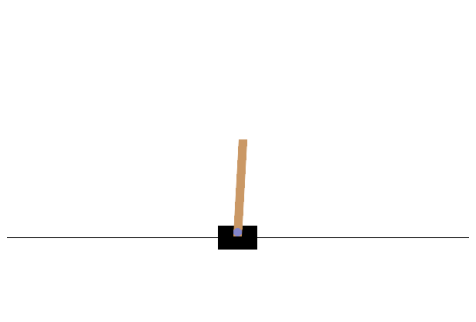

In [188]:
frames = []
for i in range(200):
    # Display the current state of the environment
    frames.append(env.render())
    # Choose a random action from the action space
    action = env.action_space.sample()
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, info = env.step(action)
    
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
save_frames_as_gif(frames)
env.close()

In [189]:
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedModel, self).__init__()
        self.soft = torch.nn.Softmax(dim = -1)
        # Define layers with ReLU activation
        self.linear1 = nn.Linear(input_size, 16)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(16, 16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 16)
        self.activation3 = nn.ReLU()

        # Output layer without activation function
        self.output_layer = nn.Linear(16, output_size)

        # Initialization using Xavier uniform (a popular technique for initializing weights in NNs)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.soft(self.output_layer(x))
        return x

    
class QNetwork:
    def __init__(self, env, lr, logdir=None):
        # Define Q-network with specified architecture
        self.net = FullyConnectedModel(4, 2)
        self.env = env
        self.lr = lr 
        self.logdir = logdir
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

    def load_model(self, model_file):
        # Load pre-trained model from a file
        return self.net.load_state_dict(torch.load(model_file))

    def load_model_weights(self, weight_file):
        # Load pre-trained model weights from a file
        return self.net.load_state_dict(torch.load(weight_file))
    
class QPolicy:
    def __init__(self, s_size, a_size):
        self.net = FullyConnectedModel(s_size,a_size)

    def act(self, state):
        state = torch.tensor(state)
        probs = self.net(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [225]:
qnet = QNetwork(env,1e-1)
qpol = QPolicy(4,2)


In [191]:
env.step(1)

(array([-0.02641339, -0.5586411 ,  0.09430214,  0.94906044], dtype=float32),
 1.0,
 False,
 False,
 {})

In [217]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        env.reset()
        
        for t in range(max_t):
            state = env.state
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, truncated , _ = env.step(action)
            rewards.append(reward)
            if done or truncated:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the discounted returns at each timestep,
        # as
        #      the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        #
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...

        # Given this formulation, the returns at each timestep t can be computed
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...

        ## Given the above, we calculate the returns at timestep t as:
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * disc_return_t + rewards[t])

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = 0
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss += (-log_prob * disc_return)

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))

    return scores

In [220]:
cartpole_hyperparameters = {
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-3,
    "env_id": env,
    "state_space": 4,
    "action_space": 2,
}

In [221]:
# Create policy and place it to the device
cartpole_hyperparameters = {
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-3,
    "env_id": env,
    "state_space": 4,
    "action_space": 2,
}
cartpole_policy = QPolicy(
    cartpole_hyperparameters["state_space"],
    cartpole_hyperparameters["action_space"],
)
cartpole_optimizer = optim.Adam(cartpole_policy.net.parameters(), lr=cartpole_hyperparameters["lr"])

In [222]:
scores = reinforce(
    cartpole_policy,
    cartpole_optimizer,
    cartpole_hyperparameters["n_training_episodes"],
    cartpole_hyperparameters["max_t"],
    cartpole_hyperparameters["gamma"],
    10,
)

Episode 10	Average Score: 14.30
Episode 20	Average Score: 18.05
Episode 30	Average Score: 17.57
Episode 40	Average Score: 17.57
Episode 50	Average Score: 18.12
Episode 60	Average Score: 19.02
Episode 70	Average Score: 18.79
Episode 80	Average Score: 18.89
Episode 90	Average Score: 19.89
Episode 100	Average Score: 20.74
Episode 110	Average Score: 21.89
Episode 120	Average Score: 22.75
Episode 130	Average Score: 23.26
Episode 140	Average Score: 23.98
Episode 150	Average Score: 24.59
Episode 160	Average Score: 24.59
Episode 170	Average Score: 25.77
Episode 180	Average Score: 27.25
Episode 190	Average Score: 26.72
Episode 200	Average Score: 26.69
Episode 210	Average Score: 27.82
Episode 220	Average Score: 29.15
Episode 230	Average Score: 29.75
Episode 240	Average Score: 30.23
Episode 250	Average Score: 32.06
Episode 260	Average Score: 34.59
Episode 270	Average Score: 36.39
Episode 280	Average Score: 36.32
Episode 290	Average Score: 38.71
Episode 300	Average Score: 43.08
Episode 310	Average

c:\Users\monce\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
MovieWriter imagemagick unavailable; using Pillow instead.


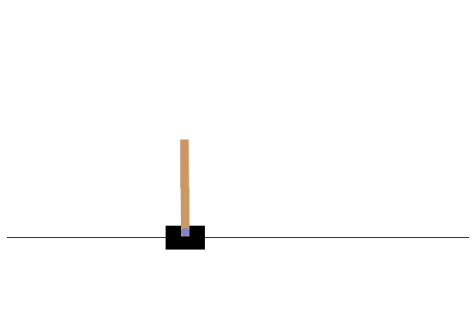

In [224]:
frames = []
for i in range(500):
    # Display the current state of the environment
    frames.append(env.render())
    # Choose a random action from the action space
    action = action, log_prob = cartpole_policy.act(env.state)
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, info = env.step(action)
    
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
save_frames_as_gif(frames)
env.close()

In [1]:
env.reset()

NameError: name 'env' is not defined